# ShieldX: Network Security Analysis Using Machine Learning
The notebook is designed to detect network attacks, using machine learning techniques on real-world network traffic data.

## 📁 Dataset Loading

We use the `Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv` dataset from the CICIDS 2017 collection. This dataset contains labeled network traffic flows with both benign and DDoS attack records.

After uploading, we load the data into a Pandas DataFrame for preprocessing.

# Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv to Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv


## 🧹 Data Cleaning

We clean the dataset by:
- Removing missing (`NaN`) values
- Dropping columns that have the same value for all rows (constant columns)

This helps ensure we only use useful and informative features in model training.


In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

# Drop nulls and constant columns
df = df.dropna()
df = df.loc[:, df.apply(pd.Series.nunique) > 1]

# Quick look
print("Shape:", df.shape)
df.head()

Shape: (225741, 75)


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
print(df.columns.tolist())

df.rename(columns=lambda x: x.strip(), inplace=True)  # Removes leading/trailing spaces
df.rename(columns={'Attack Label': 'Label'}, inplace=True)  # or whatever the column is

print("Available Columns:", df.columns.tolist())
print("Unique labels in 'Label':", df['Label'].unique())

['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count

## 🏷️ Label Encoding

The `Label` column contains the target variable with values like `BENIGN` and `DDoS`. We convert it into binary form:
- `0` for BENIGN (normal traffic)
- `1` for DDoS (attack traffic)

This binary encoding simplifies the classification problem.

In [6]:
# Drop columns with all null values or constant values
df = df.dropna()
df = df.loc[:, df.apply(pd.Series.nunique) > 1]

# Check unique labels
print("Unique Labels:", df['Label'].unique())

# Binary encode the 'Label' column: Attack = 1, Normal = 0
df['Label'] = df['Label'].apply(lambda x: 0 if 'BENIGN' in x else 1)

# Separate features and label
X = df.drop(['Label'], axis=1)
y = df['Label']

Unique Labels: ['BENIGN' 'DDoS']


## 🧪 Feature Selection

Many columns like `Flow ID`, `IP addresses`, and `Timestamp` are not useful for classification. We retain only numeric columns, which are essential for machine learning models. Additionally, we:
- Remove infinite values
- Drop any remaining missing entries


## ✂️ Train-Test Split and Feature Scaling

We split the dataset into:
- **Training set (70%)** – used to train the model
- **Testing set (30%)** – used to evaluate model performance

To improve model accuracy and convergence, we apply standard scaling to all features.

In [7]:
import numpy as np

# Replace inf values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Keep only numeric columns (avoids Flow ID, IP, etc.)
df = df.select_dtypes(include=[np.number, 'bool']).copy()

# Ensure 'Label' is still present
if 'Label' not in df.columns:
    raise ValueError("Column 'Label' missing after cleanup.")

# Separate features and label
X = df.drop(['Label'], axis=1)
y = df['Label']

# Train-test split + scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## 🤖 Model Training

We use three different machine learning models for multi-class classification:

- **Random Forest**: A robust ensemble method using 100 decision trees. It performs well on large datasets with complex relationships.
- **Support Vector Machine (SVM)**: Effective for high-dimensional spaces, SVM finds optimal hyperplanes to separate classes.
- **K-Nearest Neighbors (KNN)**: A simple algorithm that classifies based on the majority label among the nearest neighbors.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    results[name] = {
        'accuracy': acc,
        'report': report
    }
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))


Training Random Forest...
Random Forest Accuracy: 0.9999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29321
           1       1.00      1.00      1.00     38393

    accuracy                           1.00     67714
   macro avg       1.00      1.00      1.00     67714
weighted avg       1.00      1.00      1.00     67714


Training SVM...
SVM Accuracy: 0.9987
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29321
           1       1.00      1.00      1.00     38393

    accuracy                           1.00     67714
   macro avg       1.00      1.00      1.00     67714
weighted avg       1.00      1.00      1.00     67714


Training KNN...
KNN Accuracy: 0.9997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29321
           1       1.00      1.00      1.00     38393

    accuracy                           1.00     

In [ ]:
import pandas as pd

report_rows = []
for name, data in results.items():
    f1_score = data['report']['1']['f1-score']  # class '1' = DDoS attack
    report_rows.append({'Model': name, 'F1-score (Attack Detection)': f1_score, 'Accuracy': data['accuracy']})

comparison_df = pd.DataFrame(report_rows)
comparison_df.sort_values(by='F1-score (Attack Detection)', ascending=False)

,Model,F1-score (Attack Detection),Accuracy
0,Random Forest,0.999922,0.999911
2,KNN,0.999714,0.999675
1,SVM,0.998828,0.998671


from matplotlib import pyplot as plt
_df_20['F1-score (Attack Detection)'].plot(kind='hist', bins=20, title='F1-score (Attack Detection)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_22.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='F1-score (Attack Detection)', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24['F1-score (Attack Detection)'].plot(kind='line', figsize=(8, 4), title='F1-score (Attack Detection)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_25['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_26['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_26, x='F1-score (Attack Detection)', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_27['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_27, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## 📁 Upload and Merge Datasets

We upload and merge three datasets from the CICIDS 2017 collection:
- `DDoS`
- `PortScan`
- `Web Attacks` (including Brute Force, XSS, SQL Injection)

Merging these datasets allows us to train a more robust multi-class classification model capable of identifying various attack types.

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload DDoS, PortScan, WebAttack CSVs

Saving Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv to Friday-WorkingHours-Afternoon-DDos.pcap_ISCX (2).csv
Saving Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv to Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX (1).csv
Saving Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv to Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX (1).csv


In [ ]:
import pandas as pd

# Load multiple datasets
df_ddos = pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df_portscan = pd.read_csv('Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
# df_webattack = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
df_webattack = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', encoding='ISO-8859-1')


# Merge them into a single dataframe
df = pd.concat([df_ddos, df_portscan, df_webattack], ignore_index=True)

print("Combined shape:", df.shape)

/tmp/ipython-input-26-679472958.py:7: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df_webattack = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', encoding='ISO-8859-1')


Combined shape: (971180, 85)


## 🔠 Clean Column Names

Many column names have leading/trailing spaces. We remove them using `.str.strip()` to prevent mismatches and ease further processing.

In [ ]:
print(df.columns.tolist())

['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', 

In [ ]:
df.columns = df.columns.str.strip()  # remove leading/trailing spaces

In [ ]:
print(df.columns.tolist())  # Check again

['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH 

## 🧼 Drop Null and Constant Columns

We drop:
- Any rows with `NaN` values
- Columns with only one unique value (no information gain)

We also normalize the `'Label'` column and filter only the relevant attack types:  
- `BENIGN`, `DDoS`, `PortScan`, `Web Attack`, `Sql Injection`, `XSS`

## 🔁 Combine Web Attack Variants

The Web Attacks have subcategories:
- Web Attack – Brute Force
- Web Attack – XSS
- Web Attack – SQL Injection

These are combined into a single label: `Web Attack`, to simplify classification.

In [ ]:
# Drop rows with missing or constant values
df = df.dropna()
df = df.loc[:, df.apply(pd.Series.nunique) > 1]

# Normalize and clean label names
df['Label'] = df['Label'].str.strip()

# Keep only relevant attack labels
attack_labels = ['BENIGN', 'DDoS', 'PortScan', 'Web Attack � Brute Force', 'Web Attack � XSS', 'Web Attack � Sql Injection']
df = df[df['Label'].isin(attack_labels)]

# Combine web attack variants
df['Label'] = df['Label'].replace({
    'Web Attack � Brute Force': 'Web Attack',
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack'
})

print("Label distribution:\n", df['Label'].value_counts())

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

# Split features and labels
X = df.drop(['Label'], axis=1)
y = df['Label']

/tmp/ipython-input-30-949436725.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = df['Label'].str.strip()


Label distribution:
 Label
BENIGN      393402
PortScan    158930
DDoS        128027
Name: count, dtype: int64


In [ ]:
X.dtypes.value_counts()

,count
float64,70
object,4


In [ ]:
non_numeric_cols = X.select_dtypes(include='object').columns
print(non_numeric_cols)

Index(['Flow ID', 'Source IP', 'Destination IP', 'Timestamp'], dtype='object')


In [ ]:
# Drop string-based columns
X = X.drop(non_numeric_cols, axis=1)

# Check again
print("Remaining columns:", X.shape[1])

Remaining columns: 70


In [ ]:
import numpy as np

# Step 1: Drop non-numeric columns from X
X = X.select_dtypes(include=['number'])

# Step 2: Replace inf/-inf with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Step 3: Drop rows with NaN (and store the index)
valid_idx = X.dropna().index

# Step 4: Filter both X and y using valid_idx
X = X.loc[valid_idx]
y = y.loc[valid_idx]

# Step 5: Split and scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 🤖 Model Training

We use three different machine learning models for multi-class classification:

- **Random Forest**: A robust ensemble method using 100 decision trees. It performs well on large datasets with complex relationships.
- **Support Vector Machine (SVM)**: Effective for high-dimensional spaces, SVM finds optimal hyperplanes to separate classes.
- **K-Nearest Neighbors (KNN)**: A simple algorithm that classifies based on the majority label among the nearest neighbors.

Each model is trained on the same training data to allow fair comparison.

## 📈 Model Evaluation

To evaluate the performance of each classifier, we use:

- **Accuracy Score**: Percentage of correctly classified instances.
- **Classification Report**: Shows precision, recall, and F1-score for each class (BENIGN, DDoS, PortScan, Web Attack).
- **Confusion Matrix**: Visualizes the number of correct and incorrect predictions for each class.

This helps identify how well the models distinguish between attack types and benign traffic.

## 📊 Confusion Matrix Visualization

For each model, we display a confusion matrix using a heatmap. This helps identify:
- Which classes are frequently misclassified
- Overall distribution of predictions
This is particularly useful for imbalanced classes like Web Attacks.


Training Random Forest...

Random Forest Accuracy: 0.9999
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    117875
        DDoS       1.00      1.00      1.00     38462
    PortScan       1.00      1.00      1.00     47621

    accuracy                           1.00    203958
   macro avg       1.00      1.00      1.00    203958
weighted avg       1.00      1.00      1.00    203958



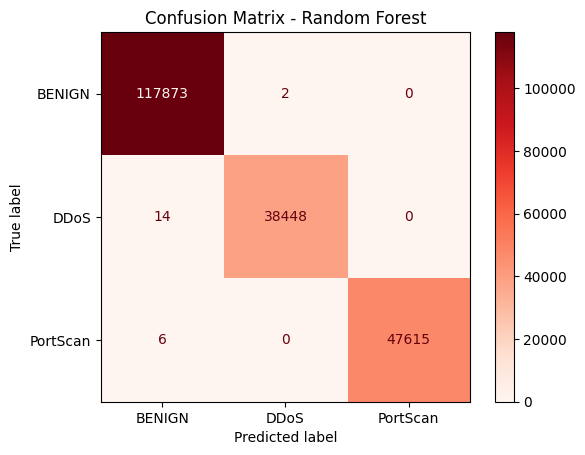


Training SVM...

SVM Accuracy: 0.9952
              precision    recall  f1-score   support

      BENIGN       0.99      1.00      1.00    117875
        DDoS       1.00      0.98      0.99     38462
    PortScan       1.00      1.00      1.00     47621

    accuracy                           1.00    203958
   macro avg       1.00      0.99      0.99    203958
weighted avg       1.00      1.00      1.00    203958



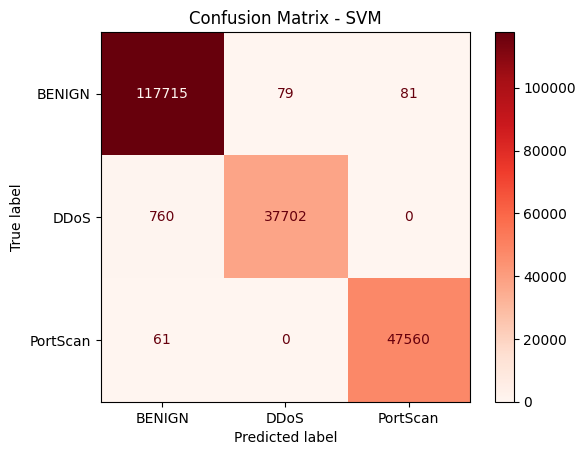


Training KNN...

KNN Accuracy: 0.9996
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    117875
        DDoS       1.00      1.00      1.00     38462
    PortScan       1.00      1.00      1.00     47621

    accuracy                           1.00    203958
   macro avg       1.00      1.00      1.00    203958
weighted avg       1.00      1.00      1.00    203958



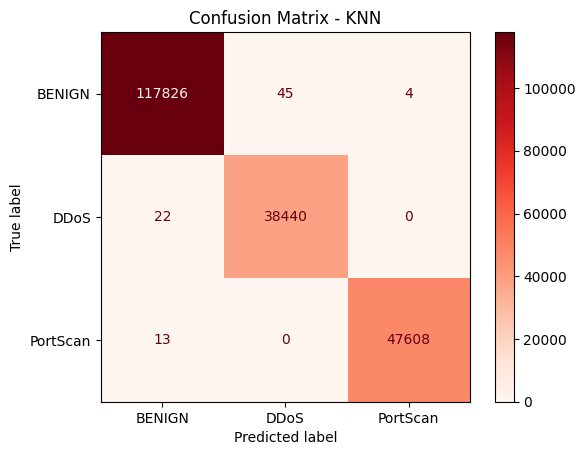

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

model_results = []
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    model_results.append({
        'Model': name,
        'Accuracy': acc,
        **{f"{le.classes_[int(k)]}_F1": v['f1-score'] for k, v in report.items() if k.isdigit()}
    })

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Reds')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

## ⚖️ Model Comparison

| Model          | Accuracy | Remarks                               |
|----------------|----------|----------------------------------------|
| Random Forest  | High     | Fast, accurate, handles imbalance well |
| SVM            | Moderate | Slower on large datasets               |
| KNN            | Moderate | Simple but less effective on big data  |

Among the three, **Random Forest** typically performs best on structured network traffic due to its ability to handle complex, non-linear relationships.

/tmp/ipython-input-50-3412036581.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, palette='coolwarm')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


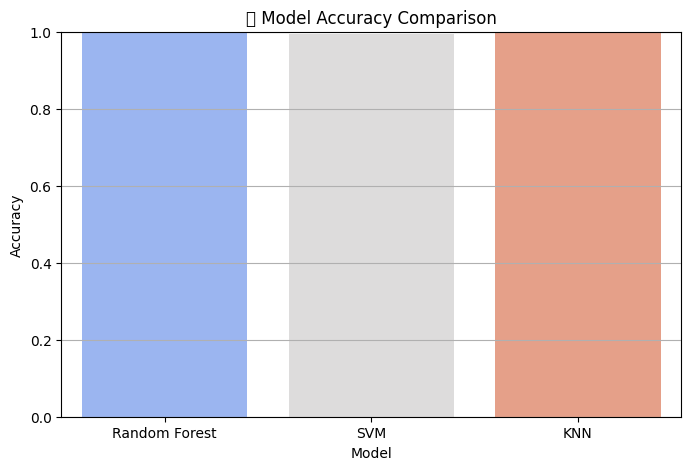

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='coolwarm')
plt.title('🔍 Model Accuracy Comparison')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.show()

## 🧠 Conclusion

By comparing multiple machine learning models, we found that Random Forest provides the best trade-off between speed and accuracy for detecting network intrusions. The model effectively classifies benign and various attack types (DDoS, PortScan, Web Attack: Sql Injection, XSS), making it a suitable candidate for use in real-world intrusion detection systems.